In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
from scipy.special import jv
#from scipy.ndimage import gaussian_filter1d
import sys

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import qgm
from qgm import image, parameter, filter, data, fitting, function

from regions import PixCoord, RectanglePixelRegion, CirclePixelRegion

cmap = image.generate_cmap(['#330000', 'r', 'w'])

In [2]:
date = '20220907'
dataNo = 1
scanNo = 1

In [3]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [4]:
param_name ='T0051: LS ramp up time  2nd (usec.)'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()
sample1 = unique_param[0]
sample2 = unique_param[0]
sample3 = unique_param[0]
unit = '[us]'
flcount = scan_data['Total count @ ROI1 (arb. u.)']

In [15]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat.tiff'))
    update_files = list(Path(path_img).glob('seq*_update.tiff'))
else:
    print('No images')

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

Text(0.5, 1.0, 'Count')

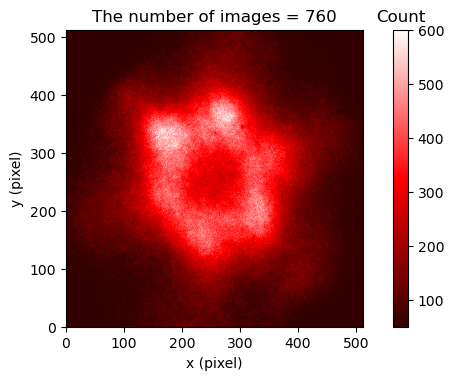

In [114]:
vmin = 50
vmax = 600
xlim_1 = 0
xlim_2 = np.shape(img_trans_ave)[0]
ylim_1 = 0
ylim_2 = np.shape(img_trans_ave)[1]

fig =plt.figure(figsize=[15,10],dpi=100)
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("The number of images = %d"%(len(img_trans_list)))
ax1.set_xlabel("x (pixel)")
ax1.set_ylabel("y (pixel)")
divider1 = make_axes_locatable(ax1)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.3)
pp=fig.colorbar(mappable,cax=ax_cb1)
pp.ax.set_title(r"Count", fontsize=12)

In [89]:
cx = 255
cy = 255
r = 25
scalingFacterDependingOnTOF = 2.5
momentum_peaks_C3_dx_list = scalingFacterDependingOnTOF*np.array([-35.646, 43.6125, -7.9659, 71.292, -87.225, 15.9318])
momentum_peaks_C3_dy_list = scalingFacterDependingOnTOF*np.array([29.7788, 15.980, -45.7598, -59.5576, -31.96,91.5196])
momentum_peaks_C2_dx_list = scalingFacterDependingOnTOF*np.array([35.6872832, -43.6125, 7.9659, -71.292, 87.225, -15.9318])
momentum_peaks_C2_dy_list = scalingFacterDependingOnTOF*np.array([-29.7788, -15.980, 45.7598, 59.5576, 31.96, -91.5196])
momentum_peaks_C1_dx_list = scalingFacterDependingOnTOF*np.array([0, 79.256753984491, -79.256753984491, 27.679518850925, -27.679518850925, -51.577235133566, 51.577235133566])
momentum_peaks_C1_dy_list = scalingFacterDependingOnTOF*np.array([0, -13.7973529288, 13.7973529288, -75.537038836463, 75.537038836463, -61.739685907663, 61.739685907663])

def calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list, momentum_peaks_C3_dx_list, momentum_peaks_C3_dy_list):
    shift_dx_list = []
    shift_dy_list = []
    list(map(lambda x: shift_dx_list.extend(x), (momentum_peaks_C1_dx_list, momentum_peaks_C2_dx_list, momentum_peaks_C3_dx_list)))
    list(map(lambda x: shift_dy_list.extend(x), (momentum_peaks_C1_dy_list, momentum_peaks_C2_dy_list, momentum_peaks_C3_dy_list)))
    subROI_cx_list = cx+np.array(shift_dx_list)
    subROI_cy_list = cy+np.array(shift_dy_list)
    return subROI_cx_list, subROI_cy_list

subROI_cx_list, subROI_cy_list = calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list, momentum_peaks_C3_dx_list, momentum_peaks_C3_dy_list)

def extractCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, np.nan)
    return extractedData

def OpticalDensityInExtractedCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, 0)
    normalizedOD = np.sum(extractedData)/np.sum(image)
    return normalizedOD

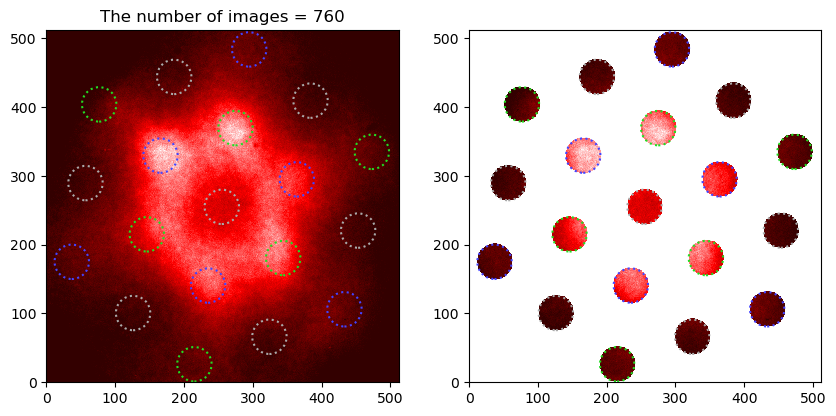

In [90]:
vmin = 50
vmax = 600
fig =plt.figure(figsize=[10,5],dpi = 100)
ax1 = fig.add_subplot(1,2,1)
mappable =ax1.pcolormesh(img_trans_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("The number of images = %d"%(len(img_trans_list)))

ax2 = fig.add_subplot(1,2,2)
for j in range(len(subROI_cx_list)):
    ax2.pcolormesh(extractCircleROI(img_trans_ave, subROI_cx_list[j], subROI_cy_list[j], r), vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)

for i in range(len(subROI_cx_list)):
    if i < len(momentum_peaks_C1_dx_list):
        color = '#aaaaaa'
    elif len(momentum_peaks_C1_dx_list)<=i<len(momentum_peaks_C1_dx_list)+len(momentum_peaks_C2_dx_list):
        color = '#22dd22'
    else:
        color = '#4444ff'
    region = CirclePixelRegion(center=PixCoord(x=subROI_cx_list[i], y=subROI_cy_list[i]), radius=r)
    region.plot(ax=ax1, color=color, lw=1.5, linestyle = ':')
    region.plot(ax=ax2, color=color, lw=1.5, linestyle = ':')

In [91]:
def calculateVisibility(trans_files, subROI_cx_list, subROI_cy_list, r):
    gamma_list = []
    k1_list = []
    k2_list = []
    visibilityOfChirality_list = []
    for j in range(len(trans_files)):
        gamma_list.append(np.sum(list(map(lambda x: OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[x], subROI_cy_list[x], r), range(0, len(momentum_peaks_C1_dx_list), 1)))))
        k1_list.append(np.sum(list(map(lambda x: OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[x], subROI_cy_list[x], r), range(len(momentum_peaks_C1_dx_list), len(momentum_peaks_C1_dx_list)+len(momentum_peaks_C2_dx_list), 1)))))
        k2_list.append(np.sum(list(map(lambda x: OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[x], subROI_cy_list[x], r), range(len(momentum_peaks_C1_dx_list)+len(momentum_peaks_C2_dx_list), len(momentum_peaks_C1_dx_list)+len(momentum_peaks_C2_dx_list)+len(momentum_peaks_C3_dx_list), 1)))))
        visibilityOfChirality_list.append((k1_list[-1]-k2_list[-1])/(k1_list[-1]+k2_list[-1]))
    x_list = np.arange(0,len(trans_files),1)
    return x_list, visibilityOfChirality_list, gamma_list, k1_list, k2_list

x_list, visibilityOfChirality_list, gamma_list, k1_list, k2_list = calculateVisibility(img_trans_list, subROI_cx_list, subROI_cy_list, r)

Text(0.5, 0, 'Number of occurence')

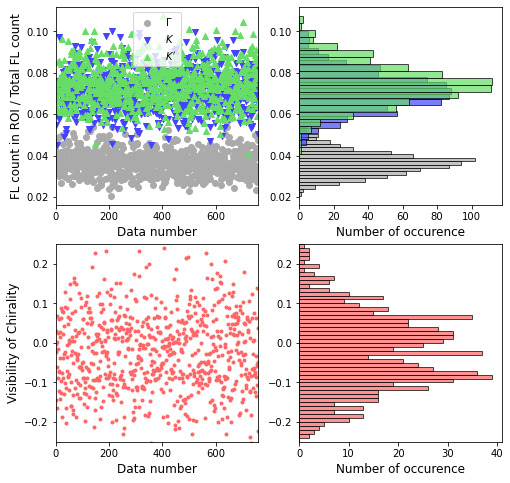

In [92]:
fig =plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(x_list, gamma_list,  marker='o', c='#aaaaaa',label=r'$\Gamma$')
ax1.scatter(x_list, k1_list, marker='v',c='#4444ff',label=r'$K$')
ax1.scatter(x_list, k2_list, marker='^',c='#66dd66',label=r'$K^{\prime}$')
ax1.set_xlabel(r'Data number',fontsize=12)
ax1.set_ylabel('FL count in ROI / Total FL count',fontsize=12)
ax1.set_xlim(0,len(img_trans_list))
ax1.legend()

ax2 = fig.add_subplot(2,2,2)
ax2.hist(np.array(gamma_list),bins=20,color='#aaaaaa', edgecolor='black', alpha=0.7,orientation='horizontal')
ax2.hist(np.array(k1_list),bins=20,color='#4444ff', edgecolor='black', alpha=0.7,orientation='horizontal')
ax2.hist(np.array(k2_list),bins=20,color='#66dd66', edgecolor='black', alpha=0.7,orientation='horizontal')
ax2.set_xlabel('Number of occurence',fontsize=12)

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(x_list,visibilityOfChirality_list, marker='o', s=9, c='#ff6666',label='Visibility')
ax3.set_xlabel(r'Data number',fontsize=12)
ax3.set_ylabel('Visibility of Chirality',fontsize=12)
ax3.set_xlim(0,len(img_trans_list))
ax3.set_ylim(-0.25,0.25)

ax4 = fig.add_subplot(2,2,4)
ax4.hist(np.array(visibilityOfChirality_list),bins=50,range=(-0.25,0.25),color='#ff6666', edgecolor='black', alpha=0.7,orientation='horizontal')
ax4.set_ylim(-0.25,0.25)
ax4.set_xlabel('Number of occurence',fontsize=12)

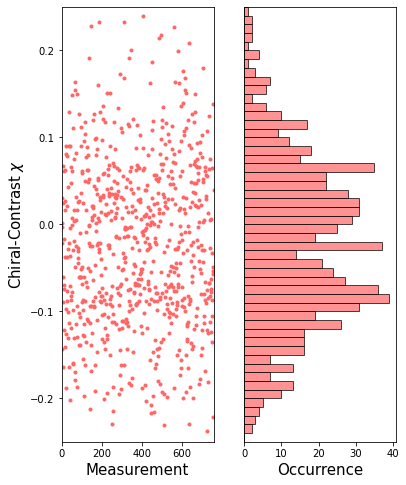

In [116]:
fig =plt.figure(figsize=[6,8])
ax3 = fig.add_subplot(1,2,1)
ax3.scatter(x_list,visibilityOfChirality_list, marker='o', s=9, c='#ff6666',label='Visibility')
ax3.set_xlabel(r'Measurement',fontsize=15)
ax3.set_ylabel(r'Chiral-Contrast $\chi$',fontsize=15)
ax3.set_xlim(0,len(img_trans_list))
ax3.set_ylim(-0.25,0.25)

ax4 = fig.add_subplot(1,2,2)
ax4.hist(np.array(visibilityOfChirality_list),bins=50,range=(-0.25,0.25),color='#ff6666', edgecolor='black', alpha=0.7,orientation='horizontal')
ax4.set_ylim(-0.25,0.25)
ax4.set_xlabel('Occurrence',fontsize=15)
ax4.yaxis.set_visible(False)

In [103]:
threshold = 0.1

def createChiralImages(trans_files, visibility_list, threshold):
    image1_list = []
    image2_list = []
    for i in range(len(trans_files)):
        if visibility_list[i] < -np.abs(threshold):
            image1_list.append(trans_files[i])
        elif visibility_list[i] > np.abs(threshold):
            image2_list.append(trans_files[i])
    image1_ave = np.average(image1_list, axis=0)
    image2_ave = np.average(image2_list, axis=0)
    return image1_ave, image2_ave, len(image1_list), len(image2_list)

post_selected_images = createChiralImages(img_trans_list, visibilityOfChirality_list, threshold)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

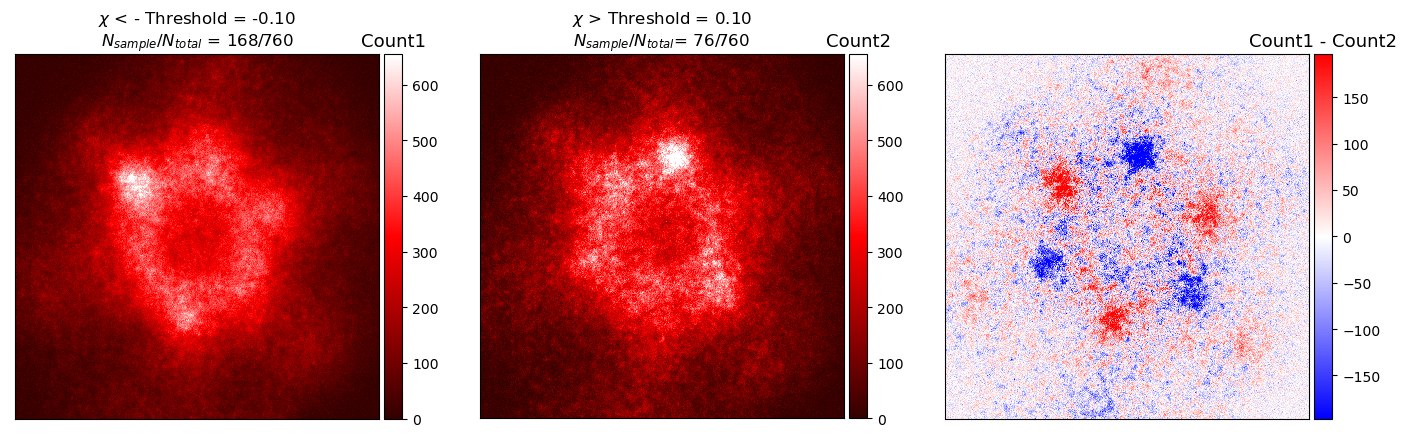

In [113]:
vmin = 0
vmax = 0.8*np.max(post_selected_images[0])
norm = mcolors.TwoSlopeNorm( vcenter=0.0, vmin=-0.3*vmax, vmax=0.3*vmax )


fig =plt.figure(figsize=[17,5],dpi=100)
ax1 = fig.add_subplot(1,3,1)
mappable =ax1.pcolormesh(post_selected_images[0], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.yaxis.set_visible(False)
ax1.xaxis.set_visible(False)
ax1.set_title(r"$\chi$ < - Threshold = %.02f"%(-np.abs(threshold))+"\n"+r"$N_{sample}/N_{total}$ = %d/%d"%(post_selected_images[2], len(img_trans_list)))
divider1 = make_axes_locatable(ax1)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb1)
pp.ax.set_title(r"Count1", fontsize=13)

ax2 = fig.add_subplot(1,3,2)
mappable = ax2.pcolormesh(post_selected_images[1], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax2.set_title(r"$\chi$ > Threshold = %.02f"%(threshold)+"\n"+r"$N_{sample}/N_{total}$= %d/%d"%(post_selected_images[3], len(img_trans_list)))
divider2 = make_axes_locatable(ax2)
ax_cb2 = divider2.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb2)
pp.ax.set_title(r"Count2", fontsize=13)

ax3 = fig.add_subplot(1,3,3)
mappable =ax3.pcolormesh(post_selected_images[0] - post_selected_images[1],cmap='bwr', norm=norm, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)
divider3 = make_axes_locatable(ax3)
ax_cb3 = divider3.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb3)
pp.ax.set_title(r"Count1 - Count2", fontsize=13)

plt.tight_layout